In [ ]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

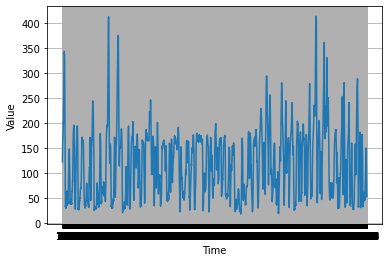

In [ ]:
hour = []
aqi = []

with open('./AQI-Hourly-2016-2017.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    aqi.append(float(row[7]))
    hour.append(row[0])

series = np.array(aqi)
time = np.array(hour)
plt.figure()
plot_series(time, series)

In [ ]:
split_time = 8477 #2016-2017 for validation set
time_train = time[:split_time]
x_train = series[:split_time]
time_validate = time[split_time:]
x_validate = series[split_time:]

window_size = 60
batch_size = 24
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    return model.predict(ds)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 24
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(8477,)
Epoch 1/50
351/351 [==============================] - 19s 13ms/step - loss: 36.8078 - mae: 37.3032 - lr: 1.0000e-07
Epoch 2/50
351/351 [==============================] - 4s 12ms/step - loss: 15.9768 - mae: 16.4631 - lr: 1.1220e-07
Epoch 3/50
351/351 [==============================] - 4s 12ms/step - loss: 12.6975 - mae: 13.1792 - lr: 1.2589e-07
Epoch 4/50
351/351 [==============================] - 4s 12ms/step - loss: 10.5960 - mae: 11.0734 - lr: 1.4125e-07
Epoch 5/50
351/351 [==============================] - 4s 12ms/step - loss: 9.2015 - mae: 9.6760 - lr: 1.5849e-07
Epoch 6/50
351/351 [==============================] - 4s 12ms/step - loss: 8.0219 - mae: 8.4922 - lr: 1.7783e-07
Epoch 7/50
351/351 [==============================] - 4s 12ms/step - loss: 7.3505 - mae: 7.8226 - lr: 1.9953e-07
Epoch 8/50
351/351 [============

(1e-07, 3e-05, 0.0, 60.0)

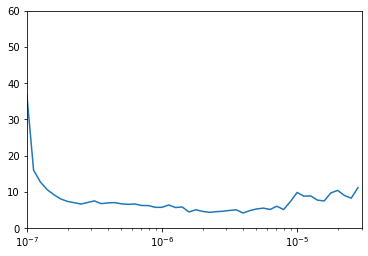

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 3e-5, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=batch_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=2.8e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
353/353 [==============================] - 6s 10ms/step - loss: 15.3355 - mae: 15.8235
Epoch 2/100
353/353 [==============================] - 4s 10ms/step - loss: 10.0992 - mae: 10.5843
Epoch 3/100
353/353 [==============================] - 3s 10ms/step - loss: 7.1860 - mae: 7.6646
Epoch 4/100
353/353 [==============================] - 3s 9ms/step - loss: 6.3577 - mae: 6.8368
Epoch 5/100
353/353 [==============================] - 3s 9ms/step - loss: 5.9716 - mae: 6.4480
Epoch 6/100
353/353 [==============================] - 4s 11ms/step - loss: 5.2413 - mae: 5.7153
Epoch 7/100
353/353 [==============================] - 3s 9ms/step - loss: 5.2002 - mae: 5.6734
Epoch 8/100
353/353 [==============================] - 4s 10ms/step - loss: 4.6337 - mae: 5.1063
Epoch 9/100
353/353 [==============================] - 3s 9ms/step - loss: 3.9563 - mae: 4.4242
Epoch 10/100
353/353 [==============================] - 3s 10ms/step - loss: 3.7554 - mae: 4.2227
Epoch 11/100
353/353 [=======

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

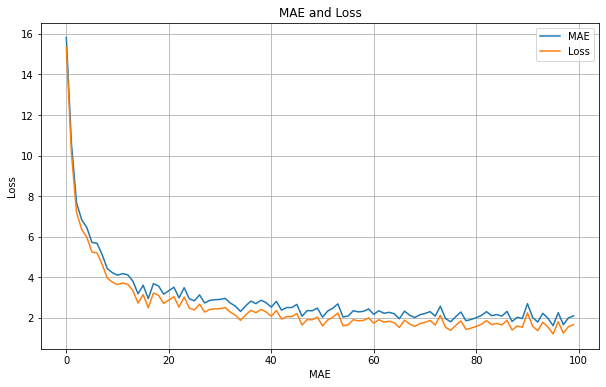

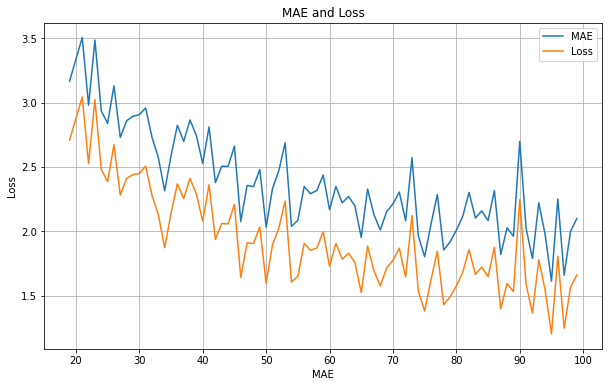

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

<Figure size 3600x432 with 0 Axes>

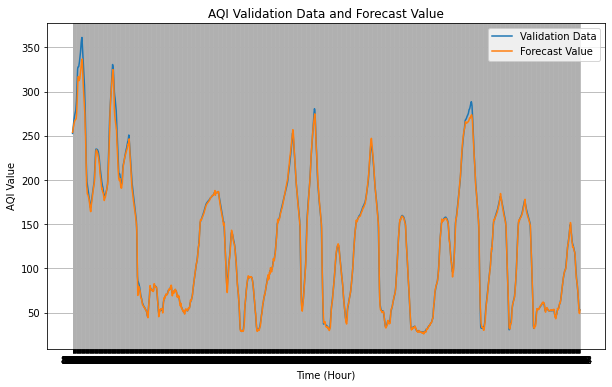

In [ ]:
plt.figure(figsize=(50, 6))
result = rnn_forecast.squeeze()
plot_series(
    x=time_validate,
    y=(x_validate, rnn_forecast),
    title='AQI Validation Data and Forecast Value', 
    xlabel='Time (Hour)',
    ylabel='AQI Value',
    legend=['Validation Data', 'Forecast Value'])

In [ ]:
print("MAE = " + str(tf.keras.metrics.mean_absolute_error(x_validate, rnn_forecast).numpy()))
print("MAPE = " + str(tf.keras.metrics.mean_absolute_percentage_error(x_validate, rnn_forecast).numpy()))

MAE = 2.470957
MAPE = 2.0133033


In [ ]:
print(rnn_forecast)

[253.96939  255.83806  259.03558  ...  50.633194  49.090023  52.98733 ]


In [ ]:
#Store forecast values to dataframe
data = {"PM25": x_validate, "PM25-Forecast": rnn_forecast}
df_forecast = pd.DataFrame(data)

In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('saved_model/AQI_hourly_v3')

INFO:tensorflow:Assets written to: saved_model/AQI_hourly_v3/assets


INFO:tensorflow:Assets written to: saved_model/AQI_hourly_v3/assets


In [ ]:
aqi_model = tf.keras.models.load_model('saved_model/AQI_hourly_v3')
# Check its architecture
aqi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 30)          1830      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
print(rnn_forecast)

[253.96939  255.83806  259.03558  ...  50.633194  49.090023  52.98733 ]


In [ ]:
import shutil
shutil.make_archive('AQI_hourly_v3', 'zip', 'saved_model/AQI_hourly_v3')

'/content/AQI_hourly_v3.zip'